# The Evals Gap
```{epigraph}
Evals are surprisingly often all you need.

-- Greg Brockman, OpenAI's President
```
```{contents}
```
## Non-Deterministic Machines

One of the most fundamental challenges when building products with Large Language Models (LLMs) is their non-deterministic nature. Unlike traditional software systems where the same input reliably produces the same output, LLMs can generate different responses each time they're queried - even with identical prompts and input data. This characteristic is both a strength and a significant engineering challenge.

When you ask ChatGPT or any other LLM the same question multiple times, you'll likely get different responses. This isn't a bug - it's a fundamental feature of how these models work. The "temperature" parameter, which controls the randomness of outputs, allows models to be creative and generate diverse responses. However, this same feature makes it incredibly difficult to build reliable, testable systems.

Consider a financial services company using LLMs to generate investment advice. The non-deterministic nature of these models means that:
- The same market data could yield different analysis conclusions
- Testing becomes exceedingly more complex compared to traditional software
- Regulatory compliance becomes challenging to guarantee
- User trust may be affected by inconsistent responses

### Temperature and Sampling

The primary source of non-determinism in LLMs comes from their sampling strategies. During text generation, the model:
1. Calculates probability distributions for each next token
2. Samples from these distributions based on temperature settings
3. Uses techniques like nucleus sampling to balance creativity and coherence

### The Temperature Spectrum

- Temperature = 0: Most deterministic, but potentially repetitive
- Temperature = 1: Balanced creativity and coherence
- Temperature > 1: Increased randomness, potentially incoherent

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

from openai import OpenAI
import pandas as pd
from typing import List

def generate_responses(
    model_name: str,
    prompt: str,
    temperatures: List[float],
    attempts: int = 3
) -> pd.DataFrame:
    """
    Generate multiple responses at different temperature settings
    to demonstrate non-deterministic behavior.
    """
    client = OpenAI()
    results = []
    
    for temp in temperatures:
        for attempt in range(attempts):
            response = client.chat.completions.create(
                model=model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=temp,
                max_tokens=50
            )
            
            results.append({
                'temperature': temp,
                'attempt': attempt + 1,
                'response': response.choices[0].message.content
            })

    # Display results grouped by temperature
    df_results = pd.DataFrame(results)
    for temp in temperatures:
        print(f"\nTemperature = {temp}")
        print("-" * 40)
        temp_responses = df_results[df_results['temperature'] == temp]
        for _, row in temp_responses.iterrows():
            print(f"Attempt {row['attempt']}: {row['response']}")
    
    return df_results

In [3]:
MAX_LENGTH = 10000 # We limit the input length to avoid token issues
with open('../data/apple.txt', 'r') as file:
    sec_filing = file.read()
sec_filing = sec_filing[:MAX_LENGTH] 
df_results = generate_responses(model_name="gpt-3.5-turbo", 
                                prompt=f"Write a single-statement executive summary of the following text: {sec_filing}", 
                                temperatures=[0.0, 1.0, 2.0])


Temperature = 0.0
----------------------------------------
Attempt 1: Apple Inc. filed its Form 10-K for the fiscal year ended September 28, 2024 with the SEC, detailing its business operations and financial performance.
Attempt 2: Apple Inc. filed its Form 10-K with the SEC for the fiscal year ended September 28, 2024, detailing its business operations, products, and financial information.
Attempt 3: Apple Inc. filed its Form 10-K with the SEC for the fiscal year ended September 28, 2024, detailing its business operations, products, and financial information.

Temperature = 1.0
----------------------------------------
Attempt 1: Apple Inc., a well-known seasoned issuer based in California, designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories, with a focus on innovation and technology.
Attempt 2: Apple Inc. filed its Form 10-K with the SEC for the fiscal year ended September 28, 2024, reporting on its business operations, products, an

This simple experiment reveals a fundamental challenge in LLM evaluation: even a simple parameter like temperature can dramatically alter model behavior in ways that are difficult to systematically assess. At temperature 0.0, responses are consistent but potentially too rigid. At 1.0, outputs become more varied but less predictable. At 2.0, responses can be wildly different and often incoherent. This non-deterministic behavior makes traditional software testing approaches inadequate.

The implications for evaluation are profound. How can one effectively test an LLM-powered system when the same prompt can yield radically different outputs based on a single parameter? Traditional testing relies on predictable inputs and outputs, but LLMs force us to grapple with probabilistic behavior. While lower temperatures may seem safer for critical applications, they don't eliminate the underlying uncertainty - they merely mask it. This highlights the need for new evaluation paradigms that can handle both deterministic and probabilistic aspects of LLM behavior.



## Emerging Properties

Beyond their non-deterministic nature, LLMs present another fascinating challenge: emergent abilities that spontaneously arise as models scale up in size. These abilities - from basic question answering to complex reasoning - aren't explicitly programmed but rather emerge "naturally" as the models grow larger and are trained on more data. This makes evaluation fundamentally different from traditional software testing, where capabilities are explicitly coded and can be tested against clear specifications.

```{figure} ../_static/evals/emerging.png
---
name: emerging-properties
alt: Emerging Properties
class: bg-primary mb-1
scale: 60%
align: center
---
Emergent abilities of large language models and the scale {cite}`wei2022emergentabilitieslargelanguage`.
```

 {numref}`emerging-properties` provides a list of emergent abilities of large language models and the scale. The relationship between model scale and emergent abilities follows a fascinating non-linear pattern. Below certain size thresholds, specific abilities may be completely absent from the model - it simply cannot perform certain tasks, no matter how much you try to coax them out. However, once the model reaches critical points in its scaling journey, these abilities can suddenly manifest in what researchers call a phase transition - a dramatic shift from inability to capability. This unpredictable emergence of capabilities stands in stark contrast to traditional software development, where features are deliberately implemented and can be systematically tested.

The implications for evaluation are profound. While conventional software testing relies on stable test suites and well-defined acceptance criteria, LLM evaluation must contend with a constantly shifting landscape of capabilities. What worked to evaluate a 7B parameter model may be completely inadequate for a 70B parameter model that has developed new emergent abilities. This dynamic nature of LLM capabilities forces us to fundamentally rethink our approach to testing and evaluation.

## Problem Statement

Consider a practical example that illustrates these challenges: building a Math AI tutoring system for children powered by an LLM. In traditional software development, you would define specific features (like presenting math problems or checking answers) and write tests to verify each function. But with LLMs, you're not just testing predefined features - you're trying to evaluate emergent capabilities like adapting explanations to a child's level, maintaining engagement through conversational learning, and providing age-appropriate encouragement and emotional support.

This fundamental difference raises critical questions about evaluation:
- How do we measure capabilities that weren't explicitly programmed?
- How can we ensure consistent performance when abilities may suddenly emerge or evolve?
- What metrics can capture both the technical accuracy and the subjective quality of responses?

The challenge becomes even more complex when we consider that traditional software evaluation methods simply weren't designed for these kinds of systems - There is an evals gap between traditional software testing and LLM evaluation. We need new frameworks that can account for both the deterministic aspects we're used to testing and the emergent properties that make LLMs unique. 

{numref}`evals-table` explores how LLM evaluation differs from traditional software testing across several key dimensions:
- **Capability Assessment vs Functional Testing**: Traditional software testing validates specific functionality against predefined requirements. LLM evaluation must assess not necessarily pre-defined "emergent properties" like reasoning, creativity, and language understanding that extend beyond explicit programming.

- **Metrics and Measurement Challenges**: While traditional software metrics can usually be precisely defined and measured, LLM evaluation often involves subjective qualities like "helpfulness" or "naturalness" that resist straightforward quantification. Even when we try to break these down into numeric scores, the underlying judgment remains inherently human and context-dependent.

- **Dataset Contamination**: Traditional software testing uses carefully crafted test cases with known inputs and expected outputs (e.g., unit tests, integration tests). In contrast, LLMs trained on massive internet-scale datasets risk having already seen and memorized evaluation examples during training, which can lead to artificially inflated performance scores. This requires careful dataset curation to ensure test sets are truly unseen by the model and rigorous cross-validation approaches.

- **Benchmark Evolution**: Traditional software maintains stable test suites over time. LLM benchmarks continuously evolve as capabilities advance, making longitudinal performance comparisons difficult and potentially obsoleting older evaluation methods.

- **Human Evaluation Requirements**: Traditional software testing automates most validation. LLM evaluation may demand significant human oversight to assess output quality, appropriateness, and potential biases through structured annotation and systematic review processes.

```{table} Evals of Traditional Software vs LLMs
:name: evals-table
| Aspect                                      | Traditional Software                             | LLMs                                                                                     |
|---------------------------------------------|---------------------------------------------------|------------------------------------------------------------------------------------------|
| **Capability Assessment**          | Validates specific functionality against requirements | May assess emergent properties like reasoning and creativity                                      |
| **Metrics and Measurement**                             | Precisely defined and measurable metrics                     | Subjective qualities that resist straightforward quantification                                                      |
| **Dataset Contamination**                             | Uses carefully crafted test cases                   | Risk of memorized evaluation examples from training                                                          |
| **Benchmark Evolution**                              | Maintains stable test suites                                 | Continuously evolving benchmarks as capabilities advance                                                 |
| **Human Evaluation**                        | Mostly automated validation                                     | May require significant human oversight                                                        |
```

## Evals Design

First, it's important to make a distinction between evaluating an LLM versus evaluating an LLM-based application. While the latter offers foundation capabilities and are typically general-purpose, the former is more specific and tailored to a particular use case. Here, we define an LLM-based application as a system that uses one or more LLMs to perform a specific task. More specifically, an LLM-based application is the combination of one or more LLM models, their associated prompts and parameters to solve a particular business problem.

That differentiation is important because it changes the scope of evaluation. LLMs are usually evaluated based on their capabilities, which include things like language understanding, reasoning and knowledge. LLM-based applications, instead, should be evaluated based on their end-to-end functionality, performance, and how well they meet business requirements. That distinction has key implications for the design of evaluation systems:

- The same LLM can yield different results in different applications
- Evaluation must align with business objectives
- A great LLM doesn't guarantee a great application!

Examples of key requirements for validation are listed in {numref}`validation-requirements`.

```{table} LLM Application Testing Requirements Matrix
:name: validation-requirements
| Category | Requirement | What to Test | Why It's Important |
|----------|------------|--------------|-------------------|
| Safety | Misinformation Prevention | - Accuracy of factual statements against verified databases<br>- Consistency of responses across similar queries<br>- Rate of fabricated details or hallucinations<br>- Citation and source accuracy<br>- Response behavior with uncertainty<br>- Temporal consistency<br>- Scientific accuracy | - Prevents real-world harm from false information<br>- Maintains user trust<br>- Reduces legal and reputational risks<br>- Ensures reliable decision-making support<br>- Protects against information manipulation |
| Safety | Unqualified Advice | - Recognition of medical, legal, and financial queries<br>- Disclaimer consistency<br>- Professional referral mechanisms<br>- Boundary recognition<br>- Emergency situation handling<br>- Avoidance of specific recommendations | - Prevents harm from incorrect professional advice<br>- Reduces legal liability<br>- Protects vulnerable users<br>- Maintains professional standards<br>- Ensures appropriate expertise utilization |
| Safety | Bias Detection | - Gender, racial, and cultural bias<br>- Demographic representation<br>- Language inclusivity<br>- Stereotype avoidance<br>- Problem-solving fairness<br>- Cultural context awareness | - Prevents reinforcement of societal biases<br>- Ensures equal service quality<br>- Maintains social responsibility<br>- Protects brand reputation<br>- Supports diverse user bases |
| Safety | Privacy Protection | - PII detection and handling<br>- Data anonymization<br>- Information leakage prevention<br>- Context carryover management<br>- Compliance with regulations<br>- Security protocols | - Protects user confidentiality<br>- Ensures regulatory compliance<br>- Maintains data security<br>- Prevents privacy breaches<br>- Safeguards sensitive information |
| Cognitive | Reasoning & Logic | - Multi-step problem-solving<br>- Mathematical computation<br>- Logical fallacy detection<br>- Causal reasoning<br>- Abstract concept handling<br>- Edge case management | - Ensures reliable problem-solving<br>- Maintains computational accuracy<br>- Supports critical thinking<br>- Prevents logical errors<br>- Enables complex decision support |
| Cognitive | Language Understanding | - Context maintenance<br>- Idiom comprehension<br>- Cultural reference accuracy<br>- Sarcasm detection<br>- Technical terminology<br>- Cross-lingual capability | - Ensures effective communication<br>- Prevents misunderstandings<br>- Enables sophisticated interactions<br>- Supports diverse language needs<br>- Maintains conversation quality |
| Technical | Code Generation | - Syntax accuracy<br>- Security vulnerability scanning<br>- Performance optimization<br>- Documentation quality<br>- Error handling<br>- Cross-platform compatibility | - Ensures code reliability<br>- Prevents security issues<br>- Maintains system stability<br>- Supports development efficiency<br>- Reduces technical debt |
| Technical | System Integration | - API handling<br>- Rate limit compliance<br>- Error management<br>- Response time<br>- Resource utilization<br>- Scalability testing | - Ensures system reliability<br>- Maintains performance<br>- Enables scaling<br>- Prevents system failures<br>- Supports integration stability |
| Meta-Cognitive | Self-Awareness | - Knowledge limitation recognition<br>- Uncertainty communication<br>- Correction capabilities<br>- Feedback integration<br>- Edge case recognition<br>- Error acknowledgment | - Builds user trust<br>- Prevents overconfidence<br>- Enables appropriate use<br>- Supports improvement<br>- Maintains reliability |
| Meta-Cognitive | Communication Quality | - Message clarity<br>- Audience appropriateness<br>- Information density<br>- Explanation quality<br>- Summary accuracy<br>- Technical communication | - Ensures understanding<br>- Maintains engagement<br>- Enables knowledge transfer<br>- Builds user satisfaction<br>- Supports effective interaction |
| Ethical | Harmful Content | - Harmful request recognition<br>- Response appropriateness<br>- Content filtering<br>- Emergency handling<br>- User safety protocols<br>- Incident reporting | - Protects user safety<br>- Prevents misuse<br>- Maintains ethical standards<br>- Reduces liability<br>- Ensures responsible use |
| Ethical | Decision-Making | - Moral consistency<br>- Value alignment<br>- Decision fairness<br>- Transparency<br>- Impact assessment<br>- Stakeholder consideration | - Ensures ethical deployment<br>- Maintains standards<br>- Builds trust<br>- Supports values<br>- Prevents harmful impacts |
| Environmental | CO2 Emission | - Energy consumption per request<br>- Model size and complexity impact<br>- Server location and energy sources<br>- Request caching efficiency<br>- Batch processing optimization<br>- Hardware utilization rates<br>- Inference optimization strategies | - Reduces environmental impact<br>- Supports sustainability goals<br>- Optimizes operational costs<br>- Meets environmental regulations<br>- Demonstrates corporate responsibility |
```




### Conceptual Overview

{numref}`conceptual` demonstrates a conceptual design of key components of LLM Application evaluation. 

```{figure} ../_static/evals/conceptual.png
---
name: conceptual
alt: Conceptual Overview
scale: 40%
align: center
---
Conceptual overview of LLM-based application evaluation.
```

We observe three key components:

**1. Examples (Input Dataset):**
- Input:  Query to LLM App, e.g. user message, input file, image, audio, etc.
- Output: A reference expected outcome from the LLM application. Provide ground truth for comparison (*Optional*).
- Purpose: Provides standardized test cases for evaluation.

**2. LLM Application (Processing Layer):**
- Input: Test cases input from Examples
- Output: Generated responses/results
- Purpose: 
  * Represents different LLM implementations/vendors solving a specific task
  * Could be different models (GPT-4, Claude, PaLM, etc.)
  * Could be different configurations of same model
  * Could be different prompting strategies

**3. Evaluator (Assessment Layer):**
- Input: 
  * Outputs from LLM application
  * Reference data from Examples (*Optional*)
- Output: Individual scores for target LLM application
- Purpose:
  * Measures LLM Application performance across defined metrics
  * Applies standardized scoring criteria

Note that Examples must provide input data to the LLM Application for further evaluation. However, ground truth data is optional. We will return to this in more detail below, where we will see that ground truth data is not always available or practical. Additionally, there are approaches where one can evaluate LLM Applications without ground truth data.


A more general conceptual design is shown in {numref}`conceptual-multi`, where multiple LLM Applications are evaluated. This design allows for a more comprehensive evaluation of different configurations of LLM-based applications, e.g.:
- Fixing all application parameters and evaluating different LLM models with their default configurations
- Fixing all parameters of an LLM model and evaluating different prompting strategies

```{figure} ../_static/evals/conceptual-multi.svg
---
name: conceptual-multi
alt: Conceptual Overview
scale: 50%
align: center
---
Conceptual overview of Multiple LLM-based applications evaluation.
```

In this evaluation framework, the same inputs are provided to all LLM applications, ensuring that responses are evaluated consistently. Performance is quantified objectively for each LLM Application, and results are ranked for easy comparison. This design leads to two additional components:
**1. Scores (Metrics Layer):**
- Input: Evaluation results from Evaluator
- Output: Quantified performance metrics
- Purpose:
  * Represents performance in numerical form
  * Enables quantitative comparison among LLM applications
  * May include multiple metrics per LLM application

**2. Leaderboard (Ranking Layer):**
- Input: Scores per LLM application
- Output: Ordered ranking of LLMs with scores
- Purpose:
  * Aggregates and ranks performances across LLM applications


### Design Considerations

The design of an LLM application evaluation system depends heavily on the specific use case and business requirements. Here we list important questions for planning an LLM application evaluation system pertaining to each of the key components previously discussed:

**1. Examples (Input Dataset):**
- What types of examples should be included in the test set?
  * Does it cover all important use cases?
  * Are edge cases represented?
  * Is there a good balance of simple and complex examples?
- How do we ensure data quality?
  * Are the examples representative of real-world scenarios?
  * Is there any bias in the test set?
- Should we have separate test sets for different business requirements?
- Do we need human-validated ground truth for all examples?
- Can we use synthetic data to augment the test set?
- How can business updates be reflected in the dataset post-launch?

**2. LLM Applications:**
- What aspects of each LLM app should be standardized for fair comparison?
  * Prompt templates
  * Context length
  * Temperature and other parameters
  * Rate limiting and timeout handling
- What specific configurations impact business requirements?
  * Which LLM application variations should be tested to maximize what we learn?
  * Which LLM capabilities provide the most value for the business and how can we measure that?

**3. Evaluator Design:**
- How do we define success for different types of tasks?
  * Task-specific evaluation criteria
  * Objective metrics vs subjective assessment
- Should evaluation be automated or involve human review?
  * Balance between automation and human judgment
  * Inter-rater reliability for human evaluation
  * Cost and scalability considerations

**4. Scoring System:**
- How should different metrics be weighted?
  * Relative importance of different factors
  * Task-specific prioritization
  * Business requirements alignment
- Should scores be normalized or absolute?
- How to handle failed responses?
- Should we consider confidence scores from the LLMs?

**5. Leaderboard/Ranking:**
- How often should rankings be updated?
- Should ranking include confidence intervals?
- How to handle ties or very close scores?
- Should we maintain separate rankings for different:
  * Business requirements
  * Cost tiers
  * LLM Models


Holistically, your evaluation design should be built with scalability in mind to handle growing evaluation needs as the combination of (Example X LLM Applications X Evaluators X Scores X Leaderboards) may grow very fast, particularly for an organization that promotes rapid experimentation and iterative development (good properties!). Finally, one should keep in mind that the evaluation system itself requires validation to confirm its accuracy and reliability vis-a-vis business requirements (evaluating evaluators will be later discussed in this Chapter).

## Metrics

The choice of metric depends on the specific task and desired evaluation criteria. However, one can categorize metrics into two broad categories: **intrinsic** and **extrinsic**:

* **Intrinsic metrics** focus on the model's performance on its primary training objective, which is typically to predict the next token in a sequence.  Perplexity is a common intrinsic metric that measures how well the model predicts a given sample of text.

* **Extrinsic metrics** assess the model's performance on various downstream tasks, which can range from question answering to code generation.  These metrics are not directly tied to the training objective, but they provide valuable insights into the model's ability to generalize to real-world applications.

Here, we are particularly interested in extrinsic metrics, since we are evaluating LLM-based applications.

Another way to think about metrics is in terms of the type of the task we evaluate:
1. **Discriminative Task**:
   - Involves distinguishing or classifying between existing data points.
   - Examples: Sentiment analysis, classification, or identifying whether a statement is true or false.
2. **Generative Task**:
   - Involves creating or producing new data or outputs.
   - Examples: Text generation, image synthesis, or summarization.

For discriminative LLM-based applications may produce log-probabilities or discrete predictions, traditional machine learning metrics like accuracy, precision, recall, and F1 score can be applied. However, generative tasks may output text or images which require different evaluation approaches.

For generative tasks, a range of specialized metrics should be considered. These include match-based metrics such as exact match and prefix match, as well as metrics designed specifically for tasks like summarization and translation, including ROUGE, BLEU, and character n-gram comparisons. The selection of appropriate metrics should align with the specific requirements and characteristics of the task being evaluated. A detailed discussion of metric selection guidelines will be provided in a subsequent section.


In {numref}`key-metrics` we provide a short list of widely used extrinsic metrics that can be used to evaluate generative tasks of LLM-based applications, along with their definitions, use cases, and limitations.

```{table} Key Metrics for Evaluating Generative Tasks
:name: key-metrics
| Metric | Definition | Use Case | Limitations |
|--------|------------|----------|-------------|
| **BLEU (Bilingual Evaluation Understudy)** | Measures overlap of n-grams between generated text and reference text | Machine translation and text summarization | - Favors short outputs due to brevity penalty<br>- Insensitive to semantic meaning<br>- Requires high-quality reference texts |
| **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** | Measures overlap between n-grams, words, or sentences of generated text and references, focusing on recall | Text summarization tasks | - Biases toward long outputs<br>- Ignores semantic equivalence<br>- Heavily influenced by reference quality |
| **METEOR (Metric for Evaluation of Translation with Explicit ORdering)** | Considers synonyms, stemming, and paraphrases alongside n-gram overlap | Machine translation, where semantic equivalence matters | - Computationally expensive<br>- Subjective design of synonym/stemming databases |
| **CIDEr (Consensus-based Image Description Evaluation)** | Measures n-gram overlap weighted by TF-IDF, tailored for image captioning | Image caption generation | - Limited applicability outside captioning<br>- Heavily reliant on corpus statistics |
| **TER (Translation Edit Rate)** | Computes number of edits needed to convert hypothesis into reference text | Translation quality evaluation | - Doesn't consider semantic correctness<br>- Penalizes valid paraphrasing |
| **BERTScore** | Uses contextual embeddings from pre-trained BERT to calculate token similarity | Tasks requiring semantic equivalence | - High computational cost<br>- Performance varies with model used |
| **SPICE (Semantic Propositional Image Caption Evaluation)** | Focuses on scene graphs in image captions to evaluate semantic content | Image captioning with emphasis on semantic accuracy | - Designed only for image captions<br>- Less effective in purely textual tasks |
```

A common use case for metrics like BLEU and ROUGE is to evaluate the quality of generated summaries against reference summaries.
As an example, we will demonstrate how to evaluate the quality of SEC Filings summaries against reference summaries (e.g. analyst-prepared highlights). 

We will model our simple metrics-based evaluator with the following components:
- Input: Generated summary and reference summary
- Output: Dictionary with scores for BLEU, ROUGE_1, and ROUGE_2
- Purpose: Evaluate our LLM-based application - SEC filing summary generator

A *Reference Summary* represents the "ideal" summary. It could be prepared by humanas, e.g. expert analysts, or machine-generated. 

In our example, we are particularly interested in evaluating the quality of summaries generated by different (smaller and cheaper) LLM models compared to a *benchmark model* (larger and more expensive). We will use the following setup:
- Benchmark model: `gpt-4o`
- Test models: `gpt-4o-mini`, `gpt-4-turbo`, `gpt-3.5-turbo`


First, we define `evaluate_summaries`, a function that calculates BLEU and ROUGE scores to assess text generation quality. It takes a generated summary and reference summary as input, processes them and returns a dictionary with three scores: BLEU (n-gram overlap), ROUGE_1 (unigram comparison), and ROUGE_2 (bigram comparison). This enables quantitative comparison of generated summaries against reference texts. We use HuggingFaces' `evaluate` library to load the metrics.

```bash
pip install evaluate absl-py rouge_score
```

In [15]:
import evaluate
def evaluate_summaries(generated_summary, reference_summary):
    """
    Evaluate generated summaries against reference summaries using multiple metrics.
    
    Args:
        generated_summary (str): The summary generated by the model
        reference_summary (str): The reference/ground truth summary
        
    Returns:
        dict: Dictionary containing scores for different metrics
    """
    # Initialize metrics
    bleu = evaluate.load("google_bleu")
    rouge = evaluate.load("rouge")
    
    # Format inputs for BLEU (expects list of str for predictions and list of list of str for references)
    predictions = [generated_summary]
    references = [reference_summary]
    
    # Compute BLEU score
    bleu_score = bleu.compute(predictions=predictions, references=[references])
    
    # Compute ROUGE scores
    rouge_score = rouge.compute(predictions=predictions, references=references)
    
    # Compute Character metric    
    # Combine all scores into a single dictionary
    scores = {
        'bleu': bleu_score["google_bleu"],
        'rouge1': rouge_score['rouge1'],
        'rouge2': rouge_score['rouge2']
    }
    
    return scores

For instance, `evaluate_summaries` can be used to compare two arbitrary sentences and returns a dictionary with our chosen metrics:


In [16]:
sentence1 = "the cat sat on the mat"
sentence2 = "the cat ate the mat"
evaluate_summaries(sentence1, sentence2)


{'bleu': 0.3333333333333333,
 'rouge1': 0.7272727272727272,
 'rouge2': 0.4444444444444445}

Next, we define `generate_summary`, our simple LLM-based SEC filing summirizer application using OpenAI's API. It takes an arbitrary `model`, and an `input` text and returns the corresponding LLM's response with a summary.

In [50]:
from openai import OpenAI
client = OpenAI()

def generate_summary(model, input):
    """
    Generate a summary of input using a given model
    """
    TASK = "Generate a 1-liner summary of the following excerpt from an SEC filing."

    prompt = f"""
    ROLE: You are an expert analyst tasked with summarizing SEC filings.
    TASK: {TASK}
    """
    
    response = client.chat.completions.create(
    model=model,
        messages=[{"role": "system", "content": prompt},
                 {"role": "user", "content": input}]
    )
    return response.choices[0].message.content

Now, we define a function `evaluate_summary_models` - our benchmark evaluator - that compares text summaries generated by different language models against a benchmark model. Here's what it does:

1. Takes a benchmark model, list of test models, prompt, and input text
2. Generates a reference summary using the benchmark model and our `generate_summary` function
3. Generates summaries from all test models using `generate_summary` function
4. Evaluates each test model's summary against the benchmark using `evaluate_summaries`
5. Returns evaluation results and the generated summaries

In [51]:
def evaluate_summary_models(model_benchmark, models_test, input):
    """
    Evaluate summaries generated by multiple models
    """
    benchmark_summary = generate_summary(model_benchmark, input)

    # Generate summaries for all test models using list comprehension
    model_summaries = [generate_summary(model, input) for model in models_test]
    
    # Evaluate each model's summary against the benchmark
    evaluation_results = [evaluate_summaries(summary, benchmark_summary) for summary in model_summaries]

    return [evaluation_results, model_summaries, benchmark_summary]

Now, we are ready to run our benchmark evaluation. We define a benchmark model and a list of test models and then evaluate each test model's summary against the benchmark. We also print the generated summaries for each model.

In [27]:
model_benchmark = "gpt-4o"
models_test = ["gpt-4o-mini", "gpt-4-turbo", "gpt-3.5-turbo"]

In [ ]:
evals, model_summaries, benchmark_summary = evaluate_summary_models(model_benchmark, models_test, sec_filing)

In [30]:
print(benchmark_summary)


"Apple Inc.'s 10-K filing for the fiscal year ending September 28, 2024, outlines its operational and financial condition, detailing the company's diverse product lines, market activities, and compliance with SEC requirements."

In [46]:
# Print each model name and its summary
for model, summary in zip(models_test, model_summaries):
    print(f"{model}: \n {summary} \n---------------")



gpt-4o-mini: 
 Apple Inc. filed its Annual Report on Form 10-K for the fiscal year ending September 28, 2024, detailing its business operations, risks, and financial condition. 
---------------
gpt-4-turbo: 
 Apple Inc.'s Form 10-K for the fiscal year ended September 28, 2024, details its annual report as a well-known seasoned issuer, confirming compliance with SEC regulations and reporting on stock performances, securities, and corporate governance, while also including forward-looking statements subject to various risks. 
---------------
gpt-3.5-turbo: 
 Apple Inc. filed its Form 10-K with the SEC, revealing financial information for the fiscal year ended September 28, 2024, including details on its products and market performance. 
---------------


The benchmark summary from `gpt-4o` provides a balanced overview of the analyzed excerpt from Apple's 10-K filing, focusing on operational status, financial condition, product lines, and regulatory compliance.

When comparing our test models against the benchmark, we observe that:
- `gpt-4o-mini` provides a concise yet comprehensive summary that closely aligns with the benchmark's core message. While it omits product lines, it effectively captures the essential elements of the filing including business operations, risks, and financial condition. Its brevity and focus look (subjectively) similar to our benchmark model.

- `gpt-4-turbo` performs adequately but tends toward verbosity. While it includes relevant information about SEC compliance, it introduces peripheral details about seasoned issuer status and forward-looking statements. The additional complexity makes the summary less focused than gpt-4o-mini's version.

- `gpt-3.5-turbo` looks quite different from the benchmark. Its summary, while factually correct, is overly simplified and misses key aspects of the filing. The model captures basic financial information but fails to convey the breadth of operational and compliance details present in the benchmark summary.

Of course, the above evaluation is only based on a single example and is heavily subjective. It's a "vibe check" on our evaluation results. Now, for an objective analysis, we can look at the quantitative metrics we have chosen and use the `visualize_prompt_comparison` function we write below to visualize the performance of our test models across our predefined quantitative metrics.


```bash
pip install matplotlib
```

In [49]:
def visualize_prompt_comparison(evaluation_results, model_names):
    """
    Create a radar plot comparing different prompt variations
    
    Args:
        evaluation_results (list): List of dictionaries containing evaluation metrics
        model_names (list): List of names for each prompt variation
    """
    from evaluate.visualization import radar_plot
    
    # Format data for visualization
    plot = radar_plot(data=evaluation_results, model_names=model_names)
    return plot

/tmp/ipykernel_1652501/940173201.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


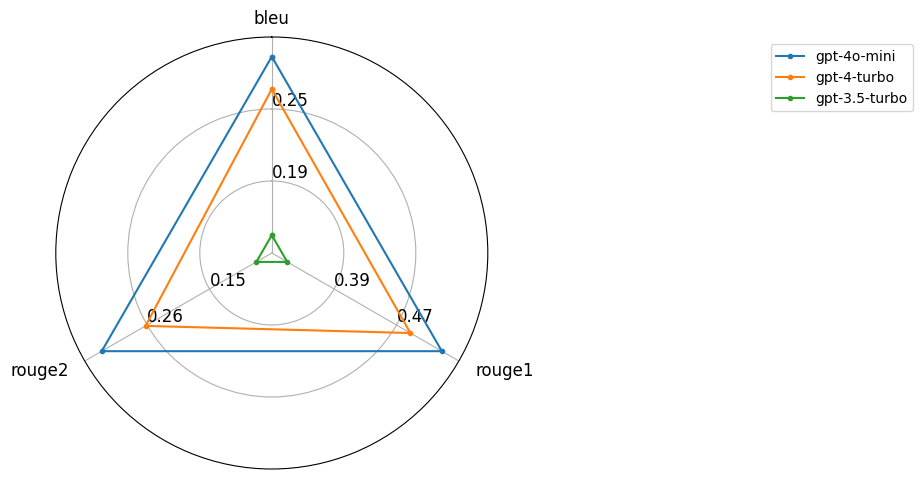

In [35]:
# Create and display visualization
plot = visualize_prompt_comparison(evals, models_test)
plot.show()

Results demonstrate that tested models perform quite differently on our predefined metrics. The evaluation metrics puts `gpt-4o-mini` as the closest aligned to the benchmark, followed by gpt-4-turbo, and gpt-3.5-turbo showing the largest deviation. This suggests that `gpt-4o-mini` is the best model for this task at least on the metrics we have chosen and for the set of models we have tested.

While evaluating language model outputs inherently involves subjective judgment, establishing a high-quality benchmark model and using quantifiable metrics provide a more objective framework for comparing model performance. This approach transforms an otherwise qualitative assessment into a measurable, data-driven evaluation process.


These metrics provide quantifiable measures of performance, however limitations should be mentioned:

*   **Task-specific nature**:  Chosen set of metrics might not fully capture the nuances of complex generative-based tasks, especially those involving subjective human judgment.
*   **Sensitivity to data distribution**: Performance on these metrics can be influenced by the specific dataset used for evaluation, which might not represent real-world data distribution.
*   **Inability to assess reasoning or factual accuracy**: These metrics primarily focus on surface-level matching and might not reveal the underlying reasoning process of the LLM or its ability to generate factually correct information.

In conclusion, selecting an appropriate extrinsic metrics set depends on the specific task, underlying business requirements and desired evaluation granularity.  Understanding the limitations of these metrics can provide a more comprehensive assessment of LLM performance in real-world applications.

To address these limitations, alternative approaches like **human-based evaluation** and **model-based evaluation** are often used, which will be discussed in the following sections.

## Evaluators

### Model-Based Evaluation

Traditional metrics like BLEU or ROUGE often fall short in capturing the nuanced, contextual, and creative outputs of LLMs. As an alternative we can consider a "Model-based evaluation" approach. A common approach is to use an LLM as a judge. This is an approach that leverages language models themselves to assess the quality of outputs from other language models. This method involves using a model (often a more capable one) to act as an automated judge, evaluating aspects like accuracy, coherence, and relevance of generated content. Unlike traditional metrics that rely on exact matching or statistical measures, model-based evaluation can capture nuanced aspects of language and provide more contextual assessment. 

As discussed in the paper {cite}`li2024leveraginglargelanguagemodels`, LLM-based evaluation approaches generally fall into two main categories:

1. **Prompt-based evaluation**: This involves using prompts to instruct existing LLMs to evaluate text quality without any fine-tuning. The evaluation can take several forms:
    - Score-based: LLMs assign numerical scores to generated text
    - Probability-based: Using generation probability as a quality metric
    - Likert-style: Rating text quality on discrete scales
    - Pairwise comparison: Directly comparing two texts
    - Ensemble methods: Combining multiple LLM evaluators
2. **Tuning-based evaluation**: This involves fine-tuning open-source LLMs specifically for evaluation tasks. This can be more cost-effective than repeatedly using API calls and allows for domain adaptation.

Once you have chosen your approach, a general LLM-as-a-Judge procedure involves the following steps (see {numref}`llm_judge`):
1. **Define Evaluation Criteria**: Establish clear benchmarks, such as relevance, coherence, accuracy, and fluency.
2. **Prepare Prompts**: Craft effective prompts to guide the LLM in evaluating content against the criteria.
3. **Define Reference Data**: Establish a set of reference data that the judge model can use to evaluate the generated outputs. (*Optional*)
4. **Run Evaluations**: Use the judge model to score outputs. Consider using a large and/or more capable model as a judge to provide more nuanced assessments.
5. **Aggregate and Analyze Results**: Interpret scores to refine applications.

```{figure} ../_static/evals/llm_judge.svg
---
name: llm_judge
alt: Conceptual Overview
scale: 60%
align: center
---
Conceptual overview of LLM-as-a-Judge evaluation.
```

Compared to traditional metrics, LLM-as-a-Judge evaluation offers a more sophisticated assessment framework by leveraging natural language criteria. While metrics focus on statistical measures, judge models excel at evaluating subjective qualities such as creativity, narrative flow, and contextual relevance - aspects that closely mirror human judgment. The judge model processes evaluation guidelines expressed in natural language, functioning similarly to a human reviewer interpreting assessment criteria. One notable consideration is that this approach requires careful prompt engineering to properly define and communicate the evaluation standards to the model.

Prompt Engineering can have a large impact on the quality of the evaluation {cite}`li2024leveraginglargelanguagemodels`. Hence, it's worth noting key prompting best practices when designing LLM-as-a-judge evaluators {cite}`huggingface2024llmjudge`:
1. Use discrete integer scales (e.g., 1-5) rather than continuous ranges 
2. Provide clear rubrics that define what each score level means
3. Include reference answers when available to ground the evaluation
4. Break down complex judgments into specific evaluation criteria

Additionally, the interpretability of the evaluation framework can be fostered by:
1. Requiring explanations and reasoning for scores to increase transparency 
2. Having a hollistic evaluation by considering multiple dimensions such as coherence, relevance, and fluency

Below we provide a sample implementation of an LLM-as-a-Judge evaluation system for our LLM application that generates SEC filing summaries. The code defines:

1. A `JudgeEvaluation` Pydantic model that enforces type validation for four key metrics:
   - Expertise: Rating of analyst-level writing quality
   - Coherence: Score for logical organization
   - Fluency: Assessment of grammar and clarity  
   - Similarity: Measure of alignment with reference text

2. An `evaluate_with_llm()` function that:
   - Takes a judge model, candidate summary, and reference summary as inputs
   - Constructs a detailed prompt instructing the LLM to act as an expert evaluator
   - Uses structured output parsing to return scores in a consistent format
   - Returns scores on a 1-10 scale for each evaluation criterion

The implementation demonstrates how to combine structured data validation with natural language evaluation to create a robust automated assessment system.

In [86]:
from pydantic import BaseModel
from typing import List, Dict

class JudgeEvaluation(BaseModel):
    expertise: int
    coherence: int
    fluency: int
    similarity: int
def evaluate_with_llm(judge_model: str, candidate_summary: str, reference_summary: str) -> Dict[str, float]:
    """
    Use an LLM to evaluate a candidate summary against a reference summary.
    
    Args:
        judge_model (str): Name of the model to use as the judge.
        candidate_summary (str): Generated summary to evaluate.
        reference_summary (str): Ground truth or benchmark summary.
    
    Returns:
        dict: Dictionary containing evaluation scores for specified criteria.
    """
    prompt = f"""
    ROLE: You are an expert evaluator of SEC Filing summaries. Evaluate the following candidate summary against the reference summary on a scale of 1 to 10 for the following criteria:
    - Expertise: Does the summary look like it was written by an expert analyst?
    - Coherence: Is the candidate summary logically organized and easy to understand?
    - Fluency: Is the language of the candidate summary clear and grammatically correct?
    - Similarity: How similar is the candidate summary compared to the reference summary?

    Reference Summary:
    "{reference_summary}"

    Candidate Summary:
    "{candidate_summary}"

    Provide scores in this format:
    Expertise: X, Coherence: Y, Fluency: Z, Similarity: W
    """
    completion = client.beta.chat.completions.parse(
        model=judge_model,
        messages=[{"role": "system", "content": prompt}],
        response_format=JudgeEvaluation
    )
    return completion.choices[0].message.parsed


Next, we define a `evaluate_summary_models` function that leverages our LLM-as-a-Judge function to compare summaries generated by different language models. Here's how it works:
   - First, it generates a benchmark summary using the specified benchmark model
   - Then, it generates summaries using each of the test models
   - Finally, it evaluates each test model's summary against the benchmark using the judge model

As a result, we get a list of evaluation results we can use to compare our candidate LLM models across our predefined metrics.


In [ ]:

def evaluate_summary_models(judge_model: str, benchmark_model: str, test_models: List[str], input_text: str):
    """
    Evaluate summaries generated by multiple models using an LLM-as-a-Judge approach.
    
    Args:
        judge_model (str): Name of the model to use as the judge.
        benchmark_model (str): Name of the benchmark model.
        test_models (list): List of model names to test.
        input_text (str): Input text for summarization.
    
    Returns:
        tuple: Evaluation results, model summaries, benchmark summary.
    """
    benchmark_summary = generate_summary(benchmark_model, input_text)
    model_summaries = [generate_summary(model, input_text) for model in test_models]

    evaluation_results = [
        evaluate_with_llm(judge_model, summary, benchmark_summary)
        for summary in model_summaries
    ]

    return evaluation_results, model_summaries, benchmark_summary

In [88]:
# Example Usage
model_benchmark = "gpt-4o"
models_test = ["gpt-4o-mini", "gpt-4-turbo", "gpt-3.5-turbo"]
judge_model = "gpt-4o"

evals, model_summaries, benchmark_summary = evaluate_summary_models(
    judge_model, model_benchmark, models_test, sec_filing
)

Here, we can see the benchmark summary coming from our benchmark model `gpt-4o`:

In [89]:
benchmark_summary

"Apple Inc.'s annual report for the fiscal year ending September 28, 2024, details its business operations, financial condition, and product lines, including iPhones, Macs, iPads, and wearables, and incorporates forward-looking statements regarding its future performance."

Next, we obtain the summaries and evaluation results generated by our test models, `gpt-4o-mini`, `gpt-4-turbo` and `gpt-3.5-turbo`, respectively.

In [90]:
model_summaries

['Apple Inc. filed its annual Form 10-K report for the fiscal year ended September 28, 2024, detailing its business operations, product lines, and financial performance.',
 "This Form 10-K filing by Apple Inc. for the fiscal year ended September 28, 2024, is an annual report detailing the company's financial performance, including registered securities, compliance with SEC reporting standards, and contains sections on business operations, risk factors, financial data, and management analysis.",
 'Apple Inc., a California-based technology company, reported an aggregate market value of approximately $2.6 trillion held by non-affiliates, with 15.1 billion shares of common stock outstanding as of October 18, 2024.']

As a result we get a list of objects of the Pydantics class we have defined `JudgeEvaluation` which contains the metrics of our evaluation (expertise, coherence, fluency and similarity).

In [91]:
evals

[JudgeEvaluation(expertise=7, coherence=8, fluency=8, similarity=7),
 JudgeEvaluation(expertise=7, coherence=7, fluency=8, similarity=5),
 JudgeEvaluation(expertise=4, coherence=5, fluency=7, similarity=2)]

/tmp/ipykernel_1652501/1775618912.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


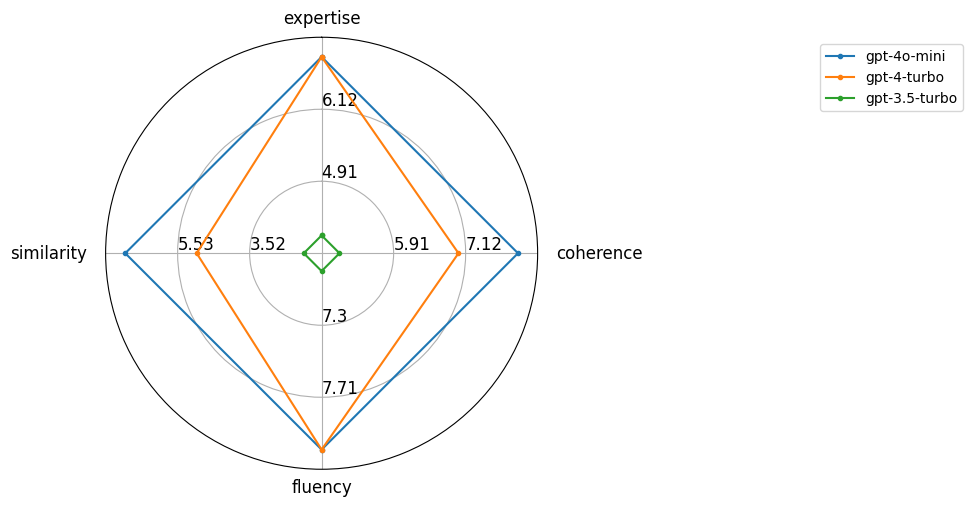

In [94]:
# Convert evaluation objects to dictionaries
evals_list = [
    {
        "expertise": eval.expertise,
        "coherence": eval.coherence, 
        "fluency": eval.fluency,
        "similarity": eval.similarity
    }
    for eval in evals
]

# Visualize results
plot = visualize_prompt_comparison(evals_list, models_test)
plot.show()


Looking at the evaluation results across our test models (gpt-4o-mini, gpt-4-turbo, gpt-3.5-turbo), we can observe some interesting patterns:

- The `gpt-4o-mini` model performed quite well, achieving high scores across all metrics (expertise: 7, coherence: 8, fluency: 8, similarity: 7). This suggests it maintained good quality while being a smaller model variant of our benchmark model `gpt-4o`.

- The `gpt-4-turbo` model showed similar expertise and fluency (7 and 8 respectively) but slightly lower coherence (7) and notably lower similarity (5) compared to the benchmark. This could indicate some drift from the reference summary while maintaining general quality.

- The `gpt-3.5-turbo` model had the lowest scores overall (expertise: 4, coherence: 5, fluency: 7, similarity: 2), particularly struggling with expertise and similarity to the benchmark. While it maintained reasonable fluency, the significant drop in similarity score suggests substantial deviation from the reference summary.

The visualization helps highlight these differences across models and evaluation dimensions. A clear performance gradient is visible from gpt-4o-mini to gpt-3.5-turbo, with the latter showing marked degradation in most metrics.



Leveraging LLMs for evaluation has several limitations {cite}`li2024leveraginglargelanguagemodels`. Firstly, computational overhead should not be neglected given the inherent cost of running additional model inferences iterations. LLM evaluators can also exhibit various biases, including order bias (preferring certain sequence positions), egocentric bias (favoring outputs from similar models), and length bias. Further, there may be a tight dependency on prompt quality - small prompt variations may lead to substantially different outcomes. It is important to also note challenges around domain-specific evaluation in fields such as medice, finance, law etc, where a general llm-as-a-judge approach may not be suitable.

The LLM-as-a-Judge strategy can serve as a scalable and nuanced solution to evaluate LLM-based applications. While it does not entirely a metrics-based or human-based aproach, it significantly augments evaluation workflows, especially in scenarios requiring evaluation of generative outputs. Future improvements could include integrating human oversight and refining LLMs for domain-specific evaluation tasks.








### Human-Based Evaluation

Human assessors can judge aspects like fluency, coherence, and factual accuracy, providing a more comprehensive evaluation. However, human evaluation can be subjective and resource-intensive.


### Evaluating Evaluators

We have discussed how LLMs can be used to evaluate LLM-based aplications. However, how can we evaluate the performance of LLMs that evaluate other LLMs? This is the question that meta evaluation aims to answer. Clearly, the discussion can become quite meta as we need to evaluate the performance of the evaluator to evaluate the performance of the evaluated model. However, one can make a case for two general options:

1. Use a gold-standard dataset that is used to evaluate the performance of LLM evaluators using a "metrics-based" approach.
2. Use a human evaluator to generate reference scores that can be used to evaluate the performance of the LLM evaluator (similar to the human-based evaluation we discussed earlier).

As depicted in {numref}`meta`, the performance of the LLM evaluator can be evaluated by comparing its scores to either a gold-standard dataset or human reference scores. Higher correlation values indicate better performance of the LLM evaluator. For instance, if we were to evaluate the performance of a LLM-as-a-judge evaluator, in the task of evaluating multilingual capability of an LLM:
1. In a "metrics-based" approach, we would first need to define a set of metrics that capture the task of multilingual capability. For instance, we could use the BLEU metric to evaluate the quality of the generated LLM output against a golden dataset (e.g. machine translated text). We would then calculate the correlation between these scores against those generated by the LLM evaluator. The higher the correlation, the better the LLM evaluator.
2. In a "human-based" approach, we would need to recruit human evaluators that are experts in the target languanges we are evaluating. Expert humans would provide scores for a set of samples of the input LLM. We would then calculate the correlation between these scores against those generated by the LLM evaluator. The higher the correlation, the better the LLM evaluator.

```{figure} ../_static/evals/meta.png
---
name: meta
alt: Meta Evaluation Conceptual Overview
scale: 30%
align: center
---
Conceptual overview of LLMs Meta Evaluation.
```

An extension of the above approaches is to use humans to directly evaluate the LLM-judges themselves. A notable example of this is [Judge Arena](https://judgearena.com/) {cite}`judgearena2024`, which is a platform that allows users to vote on which AI model made the better evaluation. Under this approach, the performance of the LLM evaluator is given by the (blind) evaluation of humans who perform the voting on randomly generated pairs of LLM judges as depicted in {numref}`meta2`. Only after submitting a vote, users can see which models were actually doing the judging.

```{figure} ../_static/evals/meta2.svg
---
name: meta2
alt: Human-in-the-loop meta evaluation Conceptual Overview
scale: 60%
align: center
---
Human-in-the-loop Meta Evaluation.
```
The LLM input and its prompt are displayed to the human evaluator and are customizable enabling task-specific meta evaluation. Further, the Judge Arena's LLM Judge's prompt is also editable by the user. Its default prompt is presented below:
> Does the model provide relevant and useful responses to the user's needs or questions?
>
> **Scoring Rubric:**
> 
> Score 1: The model's responses are irrelevant or unhelpful to the user's needs or queries.
>
> Score 2: The model sometimes provides helpful information, but often fails to address the user's actual needs or questions.
>
> Score 3: The model generally provides helpful responses that address the user's needs, though it may occasionally miss the mark.
>
> Score 4: The model regularly provides helpful responses that are well-aligned with the user's inquiries, with only rare inaccuracies.
>
> Score 5: The model consistently offers highly relevant and useful responses that perfectly cater to the user's needs and inquiries.

Judge Arena's approach and policy framework has three key benefit worth highlighting:
1. Transparency through open-source code, documentation, and data sharing
2. LLM inclusion criteria requiring scoring/critique capabilities and public accessibility
3. ELO-based leaderboard system with community involvement in evaluations

In that way, the platform enables democratic evaluation of AI judges while maintaining transparency and accessibility standards.

## Benchmarks and Leaderboards

Benchmarks act as standardized tests for LLMs, evaluating their performance across a spectrum of tasks. These tasks simulate real-world applications such as answering questions, generating coherent text, solving mathematical problems, or even writing computer code. They also assess more abstract qualities like fairness, robustness, and cultural understanding.

Benchmarks can be thought as comprehensive "exams" that probe different "subjects" in order to certify an LLM. They help researchers and developers compare models systematically, in a way LLM performance is comparable while enabling the identification of emergent behaviors or capabilities as models evolve in scale and sophistication.

The history of LLM benchmarks reflects the evolving priorities of artificial intelligence research, starting with foundational tasks and moving toward complex, real-world challenges. It began in **2018** with the introduction of **GLUE (General Language Understanding Evaluation)**, which set a new standard for evaluating natural language understanding. GLUE measured performance on tasks like sentiment analysis and textual entailment, providing a baseline for assessing the fundamental capabilities of language models. A year later, **SuperGLUE (2019)** expanded on this foundation by introducing more nuanced tasks that tested reasoning and language comprehension at a deeper level, challenging the limits of models like BERT and its successors.

As AI capabilities grew, benchmarks evolved to capture broader and more diverse aspects of intelligence. **BIG-Bench (2021)** marked a turning point by incorporating over 200 tasks, spanning arithmetic, logic, and creative problem-solving. This collaborative effort aimed to probe emergent abilities in large models, offering insights into how scale and complexity influence performance. Around the same time, specialized benchmarks like **TruthfulQA (2021)** emerged, addressing the critical need for models to provide accurate and non-deceptive information in a world increasingly dependent on AI for factual content.

In **2022**, Stanford’s **HELM (Holistic Evaluation of Language Models)** set a new standard for multidimensional assessment. HELM expanded the scope of evaluation beyond accuracy, incorporating factors like fairness, robustness, and computational efficiency. This benchmark was designed to address societal concerns surrounding AI, emphasizing safety and inclusion alongside technical performance. Similarly, **MMLU (Massive Multitask Language Understanding)**, launched in **2021**, provided a rigorous test of a model’s multidisciplinary knowledge, covering 57 subjects from STEM fields to humanities and social sciences.

Specialized benchmarks like **HumanEval (2021)** focused on domain-specific tasks, such as code generation, testing models’ ability to translate natural language descriptions into functional programming code. In contrast, **LMSYS (2023)** brought real-world applicability into focus by evaluating conversational AI through multi-turn dialogues. LMSYS prioritized coherence, contextual understanding, and user satisfaction, providing a practical lens for assessing models like GPT and Claude in dynamic settings.

From the early days of GLUE to the groundbreaking ARC Prize, the history of benchmarks illustrates a steady progression toward holistic and meaningful AI evaluation. Each new benchmark addresses emerging challenges and raises the bar for what AI systems can and should achieve, ensuring that these technologies align with both technical ambitions and societal needs.

As LLM benchmarks develop so do leaderboards. Leaderboards serve as standardized platforms to compare and rank models based on specific performance metrics / benchmarks. These evaluation systems help track LLM capabilities while maintaining transparency and reproducibility.

The **HuggingFace Open LLM** Leaderboard stands out for its transparency and accessibility in the open-source community. This leaderboard evaluates a wide range of LLMs across diverse tasks, including general knowledge, reasoning, and code-writing. Its commitment to reproducibility ensures that results are verifiable, enabling researchers and practitioners to replicate findings. By focusing on open-source models, it democratizes AI research and fosters innovation across communities, making it a valuable resource for both academics and industry professionals.

The **Chatbot Arena** Leaderboard (formerly LMSYS) takes an alternative approach by measuring real-world performance through direct model comparisons. Its evaluation format compares models in live conversations, with human judges providing qualitative assessments. This methodology has gathered over 200,000 human evaluations, offering specific insights into practical model performance. The emphasis on interactive capabilities makes it relevant for developing user-facing applications like virtual assistants and chatbots.

The **AlpacaEval** and **MT-Bench** Leaderboards implement automated evaluation using GPT-4 to assess model performance in multi-turn conversations. This approach enables consistent assessment of dialogue capabilities while reducing human bias. Their methodology measures key aspects of conversational AI, including contextual understanding and response consistency across multiple exchanges.

A significant shift in AI evaluation came with the launch of the **The Alignment Research Center (ARC) Prize** by ARC Prize Inc., a non-profit for the public advancement of open artificial general intelligence. Hosted by Mike Knoop (Co-founder, Zapier) and François Chollet (Creator of ARC-AGI, Keras), this prize represents a paradigm shift in how we evaluate language models. Rather than focusing on narrow performance metrics, the ARC Prize assesses what it calls "cognitive sufficiency" - a model's ability to generate meaningful insights and tackle open-ended challenges. This new way to think about LLM evaluation emphasizes creative thinking, sophisticated reasoning, and the capacity to make genuinely useful contributions to human knowledge as we seek to define and measure what it means to achieve AGI (Artificial General Intelligence).


Defining AGI according to ARC Prize:
> Consensus but wrong:
> - AGI is a system that can automate the majority of economically valuable work.

> Correct:
> - AGI is a system that can efficiently acquire new skills and solve open-ended problems.


The ARC benchmark distinguishes itself from other LLM benchmarks especially in its resistance to memorization by prioritizing: 
- Focus on Core Knowledge: Unlike LLM benchmarks that test a broad range of knowledge and skills, often relying heavily on memorization, ARC focuses on core knowledge similar to what a four or five-year-old child might possess. This includes basic concepts like object recognition, counting, and elementary physics.

- Novelty of Tasks: Each ARC puzzle is designed to be novel, meaning it's something you likely wouldn't have encountered before, even if you had memorized the entire internet. This characteristic directly challenges the way LLMs typically operate, which is by leveraging their vast "interpolative memory."

- Emphasis on Program Synthesis: ARC tasks require models to synthesize new solution programs on the fly for each unique puzzle. This stands in contrast to the more common LLM approach of retrieving pre-existing solution programs from memory.

- Resistance to Brute Force Attempts: While acknowledging the possibility, ARC aims to be resistant to brute-force approaches where a model might be trained on millions of similar puzzles to achieve a high score by relying on overlap with the test set.

ARC-AGI tasks are a series of three to five input and output tasks followed by a final task with only the input listed (e.g. {numref}`arc`). Each task tests the utilization of a specific learned skill based on a minimal number of cognitive priors. A successful submission is a pixel-perfect description (color and position) of the final task's output.
```{figure} ../_static/evals/arc.png
---
name: arc
alt: ARC-AGI Task
scale: 50%
align: center
---
Sample ARC-AGI Task.
```


These features make the ARC benchmark a unique test of machine intelligence, focusing on the ability to adapt to novelty and solve problems without relying heavily on memorization. This is more aligned with the concept of general intelligence, which emphasizes the ability to learn efficiently and tackle new challenges.

As language models continue to advance in capability and complexity, evaluation frameworks must evolve. Modern benchmarks increasingly incorporate tests for nuanced reasoning, ethical decision-making, and emergent capabilities that weren't previously measurable. This ongoing evolution reflects a deeper understanding that the true value of language models lies not in achieving high scores on standardized tests with narrow task-specific metrics, but in their ability to meaningfully contribute to human understanding and help solve real-world problems while demonstrating the ability to learn and adapt to new tasks.

## Tools

### LightEval

LightEval {cite}`lighteval` is a lightweight framework for evaluation of LLMs across a variety of standard and bespoke metrics and tasks across multiple inference backends via Python SDK and CLI.

As a motivating example, consider a scenario where financial data has been extracted from SEC financial filings and require econometric analysis. Tasks like estimating autoregressive models for time series forecasting or conducting hypothesis tests on market efficiency are common in financial analysis. Let's evaluate how well different models perform on this type of task.

First, we need to select a benchmark to assess LLMs capabilities in this domain. MMLU has a sub-benchmark called Econometrics we can use for this task. {numref}`mmlu-econometrics` shows a sample of the benchmark dataset from MMLU Econometrics. It consists of multiple-choice questions from econometrics and expected answers.

```{table} MMLU Econometrics Task Dataset sample
:name: mmlu-econometrics
| Question | Options | Correct Options | Correct Options Index | Correct Options Literal |
|-----------|----------|-----------------|---------------------|----------------------|
| Consider the following AR(1) model with the disturbances having zero mean and unit variance: yt = 0.2 + 0.4 yt-1 + ut The (unconditional) mean of y will be given by | ["0.2", "0.4", "0.5", "0.33"] | ["b"] | [3] | ["0.33"] |
| Suppose that a test statistic has associated with it a p-value of 0.08. Which one of the following statements is true? (i) If the size of the test were exactly 8%, we... | ["(ii) and (iv) only", "(i) and (iii) only", "(i), (ii), and (iii) only", "(i), (ii), (iii), and (iv)"] | ["c"] | [2] | ["(i), (ii), and (iii) only"] |
| What would be then consequences for the OLS estimator if heteroscedasticity is present in a regression model but ignored? | ["It will be biased", "It will be inconsistent", "It will be inefficient", "All of (a), (b) and (c) will be true."] | ["c"] | [2] | ["It will be inefficient"] |
| Suppose now that a researcher wishes to use information criteria to determine the optimal lag length for a VAR. 500 observations are available for the bivariate VAR... | ["1 lag", "2 lags", "3 lags", "4 lags"] | ["c"] | [2] | ["3 lags"] |
```

The code sample below demonstrates the LightEval Python SDK framework for evaluating a target LLM model on a given task.

```bash
pip install lighteval[accelerate]
```

```python
import lighteval
from lighteval.logging.evaluation_tracker import EvaluationTracker
from lighteval.models.model_config import BaseModelConfig
from lighteval.pipeline import ParallelismManager, Pipeline, PipelineParameters
from lighteval.utils.utils import EnvConfig
from lighteval.utils.imports import is_accelerate_available
from datetime import timedelta
from accelerate import Accelerator, InitProcessGroupKwargs


def create_evaluation_pipeline(output_dir: str, cache_dir: str, pretrained: str, dtype: str = "float16", max_samples: int = 10, task: str):
    if is_accelerate_available():
        from accelerate import Accelerator, InitProcessGroupKwargs
        accelerator = Accelerator(kwargs_handlers=[InitProcessGroupKwargs(timeout=timedelta(seconds=3000))])
    else:
        accelerator = None

    evaluation_tracker = EvaluationTracker(
        output_dir=output_dir,
        save_details=True,
        push_to_hub=False  
    )

    pipeline_params = PipelineParameters(
        launcher_type=ParallelismManager.ACCELERATE,
        env_config=EnvConfig(cache_dir=cache_dir),
        override_batch_size=1,
        max_samples=max_samples
    )

    model_config = BaseModelConfig(
        pretrained=pretrained,
        dtype=dtype,
        use_chat_template=True,
        trust_remote_code=True
    )

    pipeline = Pipeline(
        tasks=task,
        pipeline_parameters=pipeline_params,
        evaluation_tracker=evaluation_tracker,
        model_config=model_config
    )
    
    return pipeline
```
{numref}`lighteval` shows a schematic representation of its key components. As inference engine, we leverage `accelerate` for distributed evaluation. `lighteval` also supports other inference backends such as `vllm` and `tgi`.

First, we instantiate an `EvaluationTracker` which manages result storage, in this example kept in a local directory `output_dir`, and tracks detailed evaluation metrics, optionally pushed to HuggingFace Hub.

Next, we instantiate an object of the class `PipelineParameters` which, in this example, configures the pipeline for parallel processing with a temporary cache in `cache_dir` also setting the maximum number of samples to process to `max_samples`. Then, in `BaseModelConfig` we set up the LLM model we would like to evaluate defined in `pretrained`.

```{figure} ../_static/evals/lighteval.png
---
name: lighteval
alt: LightEval Python SDK Sample Conceptual Overview.
scale: 35%
align: center
---
LightEval Python SDK Sample Conceptual Overview.
```

This setup allows for systematic evaluation of language model performance on specific tasks while handling distributed computation and result tracking.

The final Pipeline combines these components to evaluate in the user defined `task`, which follows the following format:

```bash
{suite}|{task}|{num_few_shot}|{0 or 1 to automatically reduce `num_few_shot` if prompt is too long}
```

The task string format follows a specific pattern with four components separated by vertical bars (|):

1. suite: The evaluation suite name (e.g., "leaderboard")
2. task: The specific task name (e.g., "mmlu:econometrics") 
3. num_few_shot: The number of few-shot examples to use (e.g., "0" for zero-shot)
4. A binary flag (0 or 1) that controls whether to automatically reduce the number of few-shot examples if the prompt becomes too long

LightEval provides a comprehensive set of evaluation tasks {cite}`lighteval_tasks` and metrics {cite}`lighteval_metrics`. The available tasks  span multiple categories and benchmarks including BigBench, MMLU, TruthfulQA, WinoGrande, and HellaSwag. The framework also supports standard NLP evaluation metrics including BLEU, ROUGE, Exact Match, F1 Score, and Accuracy.

In our case, we choose to evaluate our LLMs on the MMLU econometrics task using zero-shot learning. Hence, we define the `task` as follows:

```python
task = "leaderboard|mmlu:econometrics|0|0"
```

Example usage to evaluate an LLM, for instance `meta-llama/Llama-3.2-1B-Instruct`, on the MMLU econometrics task using zero-shot learning:

```python
task = "leaderboard|mmlu:econometrics|0|0"
model = "meta-llama/Llama-3.2-1B-Instruct"
pipeline = create_evaluation_pipeline(output_dir="./evals/", cache_dir="./cache/", pretrained=model, task=task)
```

We can then evaluate the pipeline, save and show its results as follows:

```python
pipeline.evaluate()
pipeline.save_and_push_results()
pipeline.show_results()
```

The results are then stored in `output_dir` in JSON format.

The same results can be obtained by using the LightEval CLI:

```bash
lighteval accelerate --model_args "pretrained=meta-llama/Llama-3.2-1B-Instruct" --tasks "leaderboard|mmlu:econometrics|0|0" --override_batch_size 1 --output_dir="./evals/"
```

We would like to compare the performance of multiple open source models on the MMLU econometrics task. While we could download and evaluate each model locally, we prefer instead to evaluate them on a remote server to save time and resources. LightEval enables serving the model on a TGI-compatible server/container and then running the evaluation by sending requests to the server {cite}`lighteval_server`. 

For that purpose, we can leverage HuggingFace Serverless Inference API (or dedicated inference API) and set a configuration file for LightEval as shown below, where `<MODEL-ID>` is the model identifier on HuggingFace (e.g. `meta-llama/Llama-3.2-1B-Instruct`) and `<HUGGINGFACE-TOKEN>` is the user's HuggingFace API token.
```
model:
  type: "tgi"
  instance:
    inference_server_address: "https://api-inference.huggingface.co/models/<MODEL-ID>"
    inference_server_auth: "<HUGGINGFACE-TOKEN>"
    model_id: null
```

Now we can run the evaluation by sending requests to the server as follows by using the same bash command as before but now setting the `model_config_path` to the path of the configuration file we have just created (e.g. `endpoint_model.yaml`):

```bash
lighteval accelerate --model_config_path="endpoint_model.yaml" --tasks "leaderboard|mmlu:econometrics|0|0" --override_batch_size 1 --output_dir="./evals/"
```

To complete our task, we evaluate a few models from the following model families: `Llama3.2`, `Qwen2.5`, and `SmolLM2` as described in {numref}`model-families`.

```{table} Model Families Evaluated Using LightEval
:name: model-families
| Model Family | Description | Models | References |
|--------------|-------------|---------|------------|
| Llama3.2 Instruct |  LLaMA architecture-based pretrained and instruction-tuned generative models | `Llama-3.2-1B-Instruct` <br> `Llama-3.2-3B-Instruct` | {cite}`meta_llama_models` |
| Qwen2.5 Instruct |  Instruction-tuned LLMs family built by Alibaba Cloud | `Qwen2.5-0.5B-Instruct` <br> `Qwen2.5-1.5B-Instruct`<br> `Qwen2.5-3B-Instruct` | {cite}`gpt2docs,hui2024qwen2,qwen2` |
| SmolLM2 Instruct | Instruction-tuned family of compact language models built by HuggingFace | `SmolLM2-360M-Instruct` <br> `SmolLM2-1.7B-Instruct` | {cite}`allal2024SmolLM2` |
```

We can then compare the performance of these models on the MMLU econometrics task as shown in {numref}`model-comparison`.

```{figure} ../_static/evals/model-comparison.png
---
name: model-comparison
alt: Model Comparison on MMLU Econometrics Task
scale: 50%
align: center
---
Model performance comparison on MMLU Econometrics task, showing accuracy scores across different model sizes and architectures.
```

The results reveal several interesting patterns in model performance. As expected, we observe a trend where larger models consistently achieve higher accuracy scores. The evaluation shows distinct clusters among model families, with Qwen2.5, Llama-3.2, and SmolLM2 each exhibiting their own scaling characteristics, suggesting that architectural differences lead to varying degrees of efficiency as model size increases. Particularly noteworthy is the performance of the Qwen2.5 family, which demonstrates superior accuracy even at smaller model sizes when compared to Llama-3.2. 

Of course, the results should be taken with a grain of salt given the limited size of the dataset (MMLU Econometrics ~ 100), limited number of models and sizes. However, it gives a good indication of the capabilities of the different models tested with Qwen2.5 family being an interesting first candidate as a relatively small yet powerful model demonstrating a good trade-off between performance and size. Once tested on real-world data, the results will change but these initial findings are a good data-driven starting point for model selection as you begin your LLM-based application development.

In summary, LightEval is a simple yet flexible and comprehensive framework for evaluating LLMs across a wide variety of tasks and metrics. It can serve as a first step in selecting your next LLM for a specific task given the exponential growth in number of (open source) models available {cite}`hf_num_models`. Its integration with the Hugging Face ecosystem and modular architecture make it particularly powerful for evaluating open source models. For further details, visit the [official repository](https://github.com/huggingface/lighteval) {cite}`lighteval`.

### LangChain

### PromptFoo

PromptFoo {cite}`promptfoo` is a framework for evaluating the quality of prompts for LLMs.



## References
```{bibliography}
:filter: docname in docnames
```